In [32]:
# It allows to import files in the upper directory.
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [33]:
import ai.data_set as ds
from ai.neural_network import create_model, format_data_set, get_inputs_real_outputs
from ai.evaluation import errors

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

In [34]:
def no_bm_bm_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the NoBM BM order. In this order, the data set first contains subgrids whose the middle tile does not contain a bomb
    and then contains the subgrids whose the middle tile contains a bomb.
    Data set format: ['num_no_bm_subgrids' * 'no_bm_sg', 'num_bm_subgrids' * 'bm_sg'], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the NoBM BM order.
    """
    
    data_set = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set.extend([next(data_set_bm_gen) for i in range(num_bm_subgrids)])
    
    return data_set

def bm_no_bm_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the BM NoBM order. In this order, the data set first contains the subgrids whose the middle tile contains a bomb
    and then contains subgrids whose the middle tile does not contain a bomb.
    Data set format: ['num_bm_subgrids' * 'bm_sg', 'num_no_bm_subgrids' * 'no_bm_sg'], where 'bm_sg' is a subgrid whose the middle tile contains a bomb
    and 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the BM NoBM order.
    """
    
    data_set = [next(data_set_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set.extend([next(data_set_no_bm_gen) for i in range(num_bm_subgrids)])
    
    return data_set

def alternaten_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen, n):
    """
    Built the data set following the Alternate N order. In this order, the data set alternates between 'n' subgrids whose the middle tile does not contain a bomb
    and 'n' subgrids whose the middle tile contains a bomb.
    Data set format: ['n' * no_bm_sg', 'n' * 'bm_sg', 'n' * no_bm_sg', 'n' * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :n: The batch of subgrids to alternate.
    :return: The data set following the Alternate N order.
    """
    
    min_num_subgrids = min(num_no_bm_subgrids, num_bm_subgrids)
    
    data_set = []    
    for i in range(int(min_num_subgrids / n)):
        data_set.extend([next(data_set_no_bm_gen) for j in range(n)])
        data_set.extend([next(data_set_bm_gen) for j in range(n)])
    
    return data_set

def alternate1_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the Alternate 1 order. In this order, the data set alternates between 1 subgrid whose the middle tile does not contain a bomb
    and 1 subgrid whose the middle tile contains a bomb.
    Data set format: [1 * 'no_bm_sg', 1 * 'bm_sg', 1 * 'no_bm_sg', 1 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 1 order.
    """
    
    return alternaten_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen, 1)

def alternate5_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the Alternate 1 order. In this order, the data set alternates between 5 subgrids whose the middle tile does not contain a bomb
    and 5 subgrids whose the middle tile contains a bomb.
    Data set format: [5 * 'no_bm_sg', 5 * 'bm_sg', 5 * 'no_bm_sg', 5 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 5 order.
    """
    
    return alternaten_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen, 5)

def alternate10_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the Alternate 10 order. In this order, the data set alternates between 10 subgrids whose the middle tile does not contain a bomb
    and 10 subgrids whose the middle tile contains a bomb.
    Data set format: [10 * 'no_bm_sg', 10 * 'bm_sg', 10 * 'no_bm_sg', 10 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 10 order.
    """
    
    return alternaten_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen, 10)

def alternate15_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the Alternate 1 order. In this order, the data set alternates between 15 subgrids whose the middle tile does not contain a bomb
    and 15 subgrids whose the middle tile contains a bomb.
    Data set format: [15 * 'no_bm_sg', 15 * 'bm_sg', 15 * 'no_bm_sg', 15 * 'bm_sg', ...], where 'no_bm_sg' is a subgrid whose the middle tile does not contain a bomb
    and 'bm_sg' is a subgrid whose the middle tile contains a bomb.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Alternate 15 order.
    """
    
    return alternaten_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen, 15)

def random_order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen):
    """
    Built the data set following the Random order. In this order, the ordre of the data set is random.
    
    :num_no_bm_subgrids: The number of sugrids whose the middle tile does not contain a bomb.
    :num_bm_subgrids: The number of sugrids whose the middle tile contains a bomb.
    :data_set_no_bm_gen: The generator of the data set containing subgrids whose the middle tile does not contain a bomb.
    :data_set_bm_gen: The generator of the data set containing subgrids whose the middle tile contains a bomb.
    :return: The data set following the Random order.
    """
    
    data_set = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids)]
    data_set.extend([next(data_set_bm_gen) for i in range(num_bm_subgrids)])
    
    random.shuffle(data_set)
    
    return data_set

order_dic = {"NoBM BM": no_bm_bm_order, "BM NoBM": bm_no_bm_order, "Alternate 1": alternate1_order, "Alternate 5": alternate5_order,
             "Alternate 10": alternate10_order, "Alternate 15": alternate15_order, "Random": random_order}

In [35]:
seed = 42

radius_subgrids = 2
num_tiles_subgrids = ((radius_subgrids * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
num_no_bm_subgrids = 50000
num_bm_subgrids = 50000
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.
num_masked_subgrids = 10

ds_no_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, False)
ds_no_bm_file_name = ds_no_bm_file_name[3:]
ds_bm_file_name = ds.data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, radius_subgrids, True)
ds_bm_file_name = ds_bm_file_name[3:]
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

random.seed(seed)
np.random.seed(int(seed)) # Makes Keras deterministic.
tf.set_random_seed(seed) # Makes TensorFlow deterministic.

# Test set.
data_set_gen = ds.read_data_set(ds_no_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set = [next(data_set_gen) for i in range(5000)]

data_set_gen = ds.read_data_set(ds_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set.extend([next(data_set_gen) for i in range(5000)])
print("Data set loaded.")

# Format the test set.
test_set = format_data_set(test_set, num_masked_subgrids)
print("Test set formatted.")

# Get the 'x' and 'y_true' vectors.
x_test, y_true_test = get_inputs_real_outputs(test_set)
print("Inputs and real outputs extracted.\n")

# Data set generators for the training set.
data_set_no_bm_gen = ds.read_data_set(ds_no_bm_file_name)
data_set_bm_gen = ds.read_data_set(ds_bm_file_name)
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

orders_to_take = ["NoBM BM", "BM NoBM", "Alternate 1", "Alternate 5", "Alternate 10", "Alternate 15", "Random"]
orders = {order: order_dic[order] for order in orders_to_take if order in order_dic}
err_list = []
for order_name, order in orders.items():
    print("{} order.".format(order_name))
    
    # Load the data set.
    data_set = order(num_no_bm_subgrids, num_bm_subgrids, data_set_no_bm_gen, data_set_bm_gen)
    print("Data set loaded.")
    
     # Format the data set.
    training_set = format_data_set(data_set, num_masked_subgrids)
    print("Data set formatted.")
    
    # Get the 'x' and 'y_true' vectors.
    x_training, y_true_training = get_inputs_real_outputs(training_set)
    print("Inputs and real outputs extracted.")

    # Create the model.
    model = create_model(num_tiles_subgrids)
    
    # Train the model.
    model.fit(x_training, y_true_training, epochs=1, batch_size=10)
    print("Neural network trained.")
    
    # Prediction and errors.
    y_pred = model.predict(x_test)
    y_pred = [y_p[0] for y_p in y_pred]

    # Errors
    error_func = lambda y_t, y_p: abs(y_t - y_p)
    err = errors(y_true_test, y_pred, error_func)
    print("Errors computed.")

    err_list.append(err)
    
    print('')

Data set loaded.
Test set formatted.
Inputs and real outputs extracted.

NoBM BM order.
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 135s 135us/step - loss: 0.1052 - mean_squared_error: 0.1052 - mean_absolute_error: 0.1927 - acc: 0.8501
Neural network trained.
Errors computed.

BM NoBM order.
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 137s 137us/step - loss: 0.1046 - mean_squared_error: 0.1046 - mean_absolute_error: 0.1930 - acc: 0.8510
Neural network trained.
Errors computed.

Alternate 1 order.
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000000/1000000 [==============================] - 136s 136us/step - loss: 0.1057 - mean_squared_error: 0.1057 - mean_absolute_error: 0.1941 - acc: 0.8493
Neural network trained.
Errors computed.

Alternate 5 order.
Data set loaded.
Data 

In [36]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
percentile_25_color = 'limegreen'
median_color = 'red'
percentile_75_color = 'limegreen'
dot_color = 'black'

save_fig = True
fig_format = 'png'
fig_dpi = 500

<IPython.core.display.Javascript object>


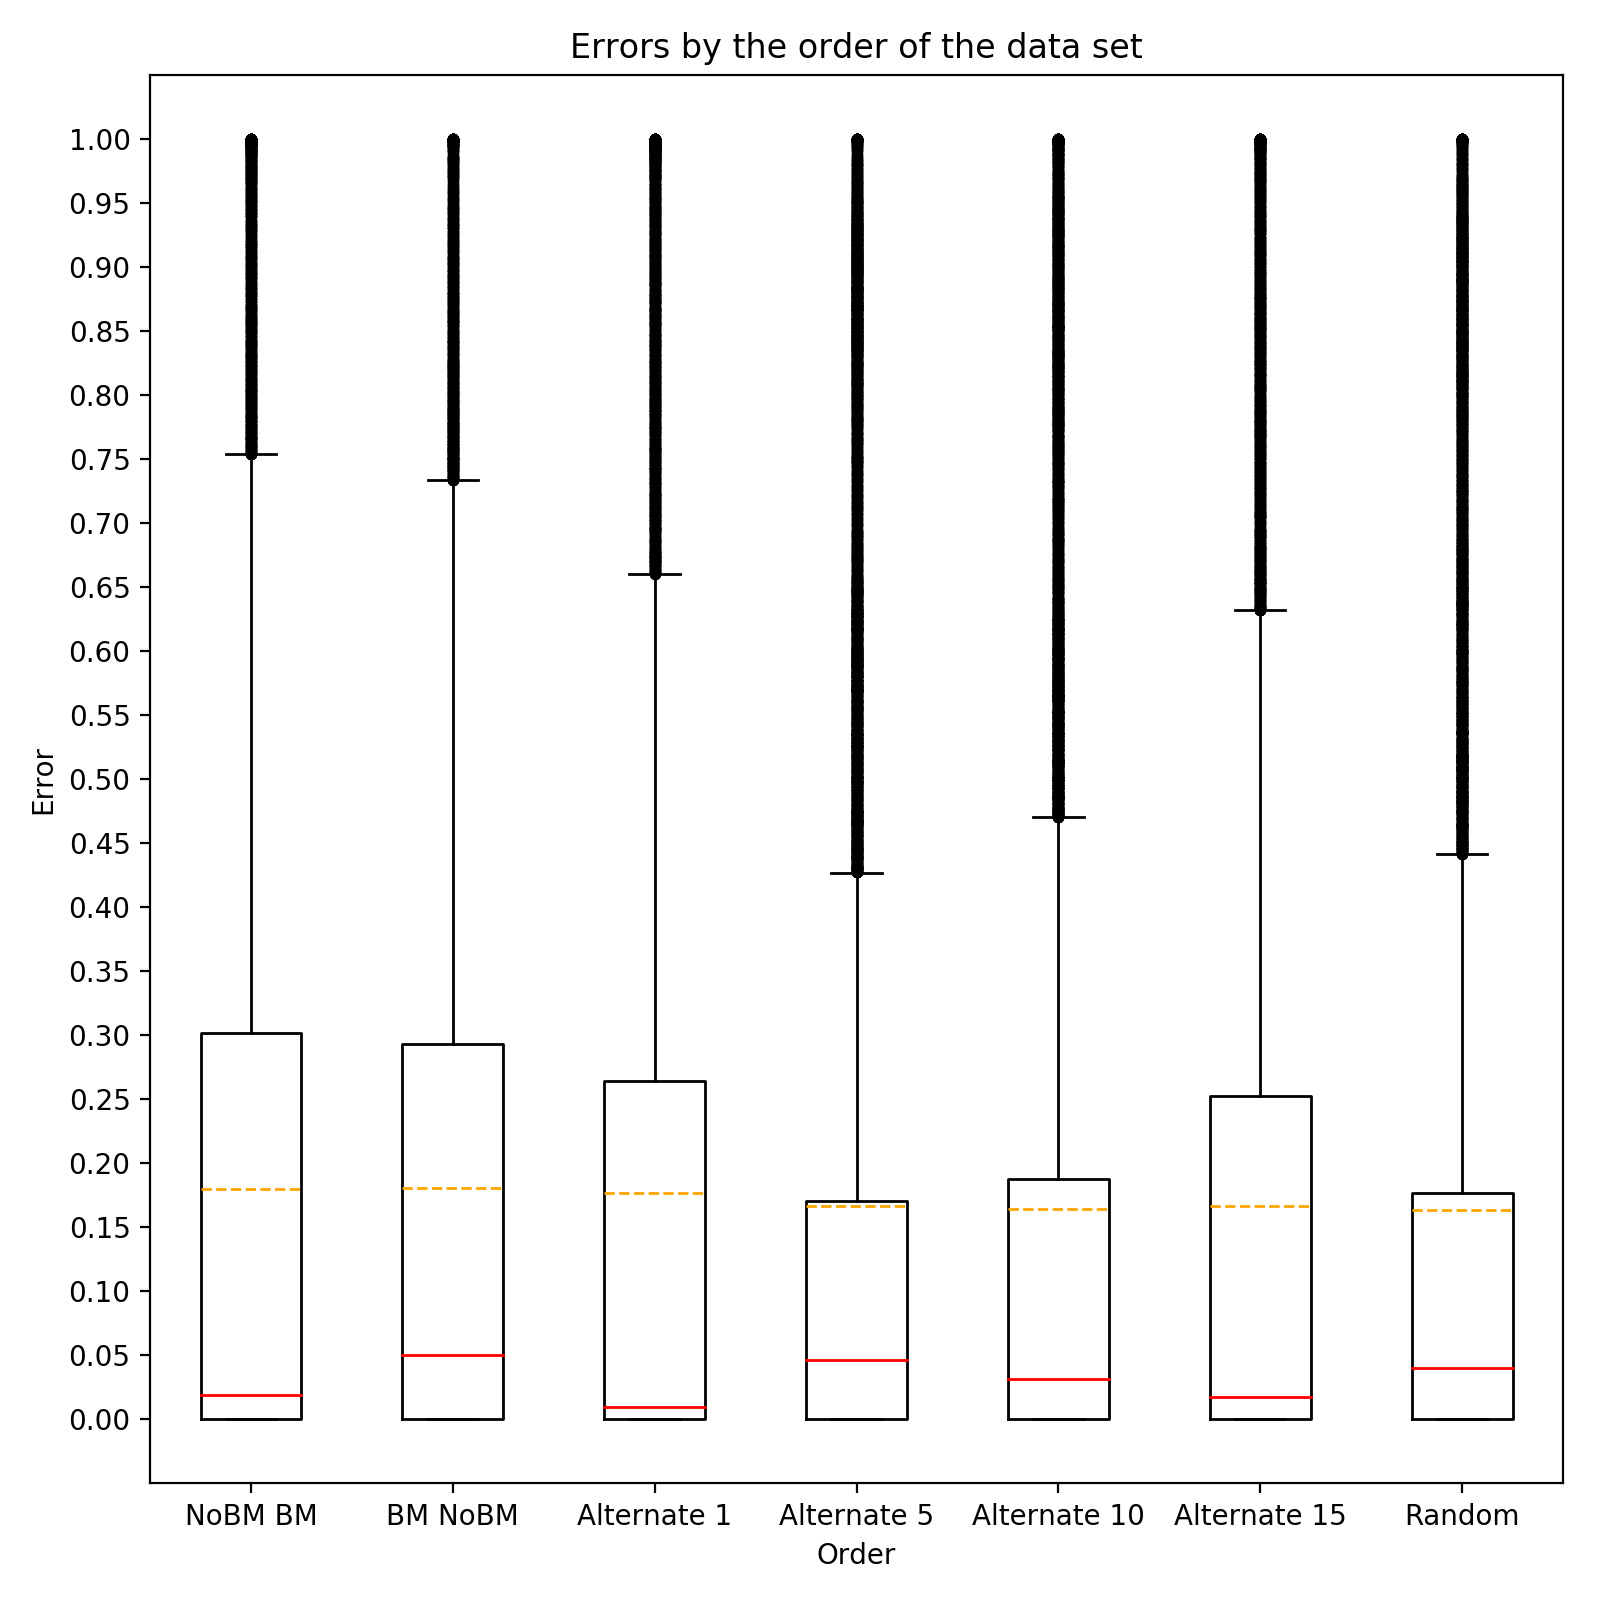

In [37]:
# Box plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
bplot = plt.boxplot(err_list, showmeans=True, meanline=True, sym='.')
plt.xticks(range(1, len(orders) + 1), orders.keys())
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the order of the data set')
plt.xlabel('Order')
plt.ylabel('Error')
plt.setp(bplot['means'], color=mean_color)
plt.setp(bplot['medians'], color=median_color)
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig(('errors_by_dataset_order.' + fig_format), format=fig_format, dpi=fig_dpi)